In [1]:
import numpy as np
import pandas as pd
import math
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display
import sys
import pickle
import seaborn
seaborn.set_style('ticks')
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

####Generate a mixing matrix for use in metapopulation code###
* Size will be npatchxnpatch
* Dispersion kernel defined by:  
$ p(d) = \frac{1}{N} \exp\left(-(d/\alpha)^c\right)$  
$\alpha$ sets the length scale of dispersion, and $c$ adjusts the 'tail fatness.' Higher $c$ means fatter (skinnier??) tails. $d$ is the distance between the points.
* Normalization constant is:  
$N = \frac{2\pi \alpha^2 \Gamma(2/c)}{c}$


In [2]:
#Set constants for the matrix you want.
n = 20         #size of an edge (even numbers make the movie easier)
npatch = n*n   #npatch is nxn - the matrix is npatchxnpatch
alpha = 1.     #length scale
cinj = 0.5        #tail weight (lower c -> higher tail weight)

In [3]:
def distance(x1,x2,y1,y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)
def kernel(d,a,c):
    N = 2.*np.pi*a*sp.special.gamma(1./c)/c
    pofd = np.exp(-((d/a)**c))
   # for i in range(len(pofd)):
    #    if pofd[i]<0.6:
     #       pofd[i] = 0.6
    return pofd/N

In [4]:
dist = np.linspace(0,35,100) #For normalization purposes, should neighboring cells be 'zero'? (Yes.)
dx = dist[1]-dist[0]

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


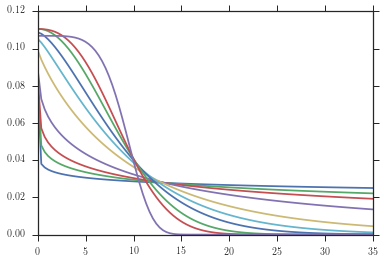

In [5]:
ctest = [0.1,0.2,0.3,0.5,0.9,1.2,1.5,2.0,2.5,5.0]
#ctest = cvar
alpha = 10.
for cinj in ctest:
    k = kernel(dist,alpha,cinj)
    k /= sum(k*dx)
    print sum(k)*dx
    plt.plot(dist,k)

In [44]:
#For a given alpha and c, you want to output an npatchxnpatch matrix with k giving the values of each cell. 
#You should only have to calculate k once - it just gets 'shifted' for each new row. The trick is to calculate 
#the distance between each point in the row. If i=j, this kernel should be the non-mixed value. Say 0.1, whatever. It's
#going to get scaled anyway.
cinj = 0.01
alpha = 10.
mixmat = np.zeros([n,n])
mixmat += 0.00001
betamat = []
for istar in range(n):
    for jstar in range(n):
        for i in range(n):
            for j in range(n):
                dist = np.abs(np.sqrt((i-istar)**2+(j-jstar)**2)-1.) #scaled so nearest (non-diagonal) neighbors are zero distance.
                if dist==0:
                    dist = 0.05
                if (i==istar)&(j==jstar):
                    dist = 0.05
                k = kernel(dist,alpha,cinj)
                mixmat[i,j] += k
        #mixmat[istar,jstar] = 2.*np.min(mixmat)
        #Scale *each of these matrices* to have the appropriate R0.
        mixvec = mixmat.flatten()
        betamat.append(mixvec)


In [45]:
betamat = np.array(betamat)
np.shape(betamat)

(400, 400)

In [46]:
#Need to scale to get desired R0. That's going to be something like 16. for measles.
R0 = 1.
gamma = 1. #Number of timesteps to recovery. Our timesteps are two weeks long, so. 
maxeig = R0*gamma

scale = np.real(np.max(np.linalg.eigvals(betamat)))
print scale

betamat *= maxeig/scale   #Scale so the maximum eigenvalue is R0
print np.max(np.linalg.eigvals(betamat))/gamma   #Check

0.004
(1+0j)


In [47]:
trial = betamat[50,:].copy()
np.shape(trial)

(400,)

In [48]:
trial = trial.reshape(n,n)
print np.max(np.linalg.eigvals(trial))

0.05


[[ 0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025
   0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025
   0.0025  0.0025]
 [ 0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025
   0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025
   0.0025  0.0025]
 [ 0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025
   0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025
   0.0025  0.0025]
 [ 0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025
   0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025
   0.0025  0.0025]
 [ 0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025
   0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025
   0.0025  0.0025]
 [ 0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025
   0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025  0.0025
   0.0025  0.0025

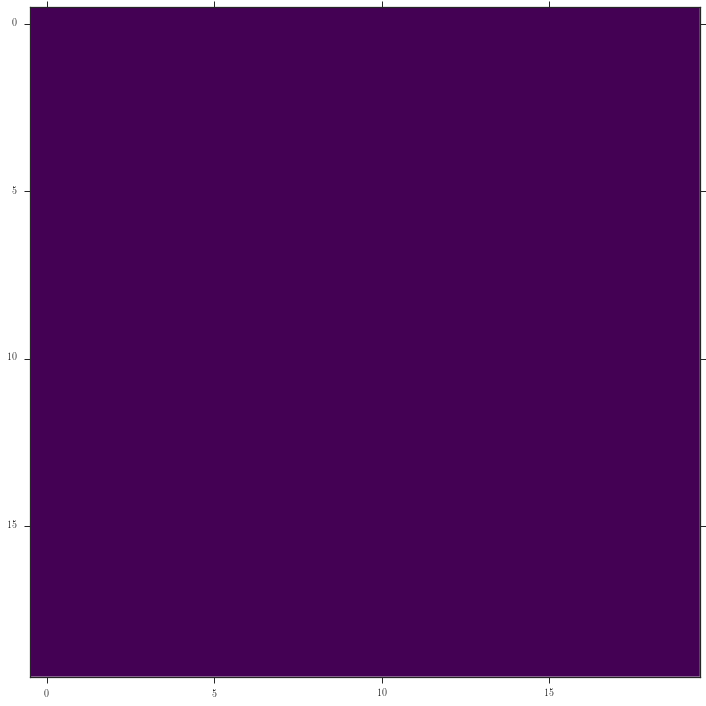

In [49]:
plt.figure(figsize=(12,12))
plt.imshow(trial,cmap='viridis',interpolation='none')

print trial

plt.savefig('mixingmatriximage.pdf')

In [18]:
filename = 'betamalpha10c5.0.hpp'
with open(filename,"w") as f:
    f.write("static std::array<std::array<float, nptch>, nptch> sbetaMatrix = {{\n")
    for row in betamat:
        f.write("{{")
        for i in range(npatch-1):
            f.write(str(row[i])+",")
        f.write(str(row[npatch-1])+"}},\n")
    f.write("}};")

In [206]:
popsize = np.linspace(5,100,10)

In [207]:
popsize

array([   5.        ,   15.55555556,   26.11111111,   36.66666667,
         47.22222222,   57.77777778,   68.33333333,   78.88888889,
         89.44444444,  100.        ])